# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [11]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [13]:

data_transforms = {
    'train': transforms.Compose([
     
        transforms.RandomRotation(15),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
       
]),

'test':transforms.Compose([
   
        transforms.ToTensor(),
     
    ]),
}
train_set=datasets.MNIST('mnist_data',train=True,download=True,transform=data_transforms['train'])
test_set=datasets.MNIST('mnist_data',train=False,download=True,transform=data_transforms['test'])
# Create training set and define training dataloader

test_dataloader=torch.utils.data.DataLoader(test_set,batch_size=64)

train_dataset, val_dataset = train_test_split(train_set, test_size=0.1, random_state=42)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)



In [14]:
test_set[0][0][0].shape

torch.Size([28, 28])

In [15]:
train_set.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

i chose to randomly rotate and flip the test images as a part of data transforms for data augmentation

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [16]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


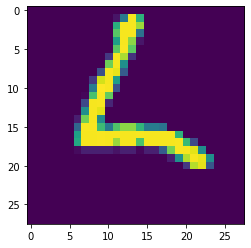

3


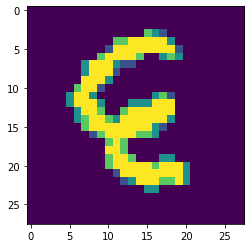

8


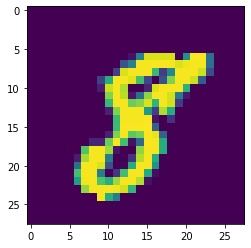

9


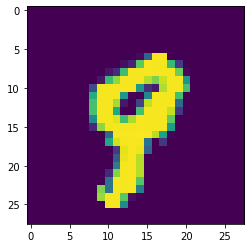

3


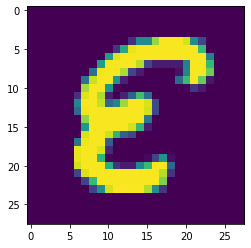

In [17]:
show5(val_dataloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [34]:
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 86),
        nn.ReLU(),
        nn.Linear(86, 10)
    )

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [35]:
loss=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [36]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
else:
    device=torch.device("cpu")
    

In [37]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [38]:
def train(num=3, lr=0.0001, device="cpu"):
    acc=[]
    cnn=model.to(device)
    max_acc=0
    for epoch in range(num):
        for i,(images,labels)in enumerate(train_dataloader):
            images=images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred=cnn(images)
            l=loss(pred,labels)
            l.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dataloader))
        acc.append(accuracy)
        if accuracy > max_acc:
            max_acc = accuracy
            print(" Accuracy: ", accuracy)
            print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(acc)

            

Plot the training loss (and validation loss/accuracy, if recorded).

 Accuracy:  82.6500015258789
Epoch: 1 Accuracy : 82.6500015258789 %
 Accuracy:  85.30000305175781
Epoch: 2 Accuracy : 85.30000305175781 %
 Accuracy:  86.48332977294922
Epoch: 3 Accuracy : 86.48332977294922 %
 Accuracy:  86.66666412353516
Epoch: 4 Accuracy : 86.66666412353516 %
 Accuracy:  87.91666412353516
Epoch: 5 Accuracy : 87.91666412353516 %
 Accuracy:  88.03333282470703
Epoch: 6 Accuracy : 88.03333282470703 %
 Accuracy:  89.13333129882812
Epoch: 7 Accuracy : 89.13333129882812 %
 Accuracy:  89.4000015258789
Epoch: 9 Accuracy : 89.4000015258789 %
 Accuracy:  89.80000305175781
Epoch: 10 Accuracy : 89.80000305175781 %


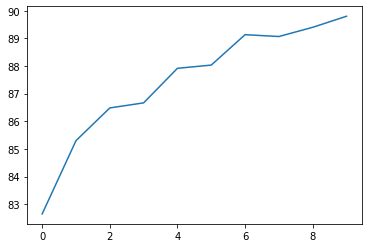

In [25]:
train(10)


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [26]:

def check_accuracy_on_test(model):
    model.to(device)
    correct,total = 0,0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
       
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on test images is: %d%%' % (100 * correct / total))

In [27]:
check_accuracy_on_test(model)

Accuracy on test images is: 91%


hyperparameter tuning

 Accuracy:  76.61666870117188
Epoch: 1 Accuracy : 76.61666870117188 %
 Accuracy:  80.88333129882812
Epoch: 2 Accuracy : 80.88333129882812 %
 Accuracy:  84.83333587646484
Epoch: 3 Accuracy : 84.83333587646484 %
 Accuracy:  86.23332977294922
Epoch: 4 Accuracy : 86.23332977294922 %
 Accuracy:  87.16666412353516
Epoch: 5 Accuracy : 87.16666412353516 %
 Accuracy:  87.8499984741211
Epoch: 6 Accuracy : 87.8499984741211 %
 Accuracy:  88.55000305175781
Epoch: 7 Accuracy : 88.55000305175781 %
 Accuracy:  88.66666412353516
Epoch: 8 Accuracy : 88.66666412353516 %
 Accuracy:  88.8499984741211
Epoch: 9 Accuracy : 88.8499984741211 %
 Accuracy:  90.16666412353516
Epoch: 10 Accuracy : 90.16666412353516 %
 Accuracy:  90.23332977294922
Epoch: 11 Accuracy : 90.23332977294922 %
 Accuracy:  90.63333129882812
Epoch: 12 Accuracy : 90.63333129882812 %
 Accuracy:  90.81666564941406
Epoch: 13 Accuracy : 90.81666564941406 %
 Accuracy:  91.25
Epoch: 14 Accuracy : 91.25 %
 Accuracy:  91.5
Epoch: 15 Accuracy : 91.5 

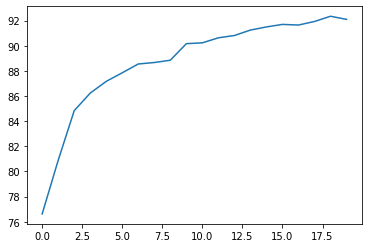

In [40]:
#changed num of epochs and learning rate

train(20,lr=0.00015)

In [41]:
check_accuracy_on_test(model)

Accuracy on test images is: 93%


## Saving your model
Using `torch.save`, save your model for future loading.

In [42]:
torch.save(model,"path.pth")